In [43]:
# 載入需要的套件
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import tensorflow as tf
import re
import os

In [3]:
import requests
from bs4 import BeautifulSoup

# 發送 GET 請求獲取證券櫃檯買賣中心 (TWSE) 的網頁內容
url = "https://isin.twse.com.tw/isin/C_public.jsp?strMode=2"
html = requests.get(url).text

# 使用 BeautifulSoup 解析網頁內容
soup = BeautifulSoup(html, "html.parser")

In [53]:
def saveToFile(category, stock):
	path = "csv/" + category + "/" + stock + ".csv"
	if not os.path.isfile(path):
		df = yf.download(stock, end = dt.date.today(), progress=False)
		df.to_csv(path)

In [55]:
# https://isin.twse.com.tw/isin/C_public.jsp?strMode=2
category_list = ["半導體業", "電機機械", "汽車工業", "化學工業", "生技醫療業", "鋼鐵工業"]

In [56]:
for category in category_list:
	path = "./csv/" + category
	if not os.path.isdir(path): os.mkdir(path)

for tr in soup.find_all("tr")[2:]:
	text = tr.find(True).text
	if re.match("[0-9]{4}　.*", text):
		category = tr.select_one(':nth-child(5)').text
		if category in category_list:
			saveToFile(category, text[0:4] + ".TW")

In [ ]:
for filename in os.scandir("./csv/" + category_list[0]):
	print(filename.path)

In [62]:
x_train = np.empty((0, 500))
y_train = np.empty((0, 5))

for c in category_list:
	for file in os.scandir("./csv/" + c):
		data = np.loadtxt(file.path, delimiter=",", skiprows=1, usecols=(1,2,3,4,5))

		x = []

		days = 100
		n, m = data.shape
		for i in range(n - days):
			sub = data[i:i + days,:]
			x.append(np.concatenate(sub, axis=0))
		x = np.array(x).reshape(-1, 500)

		y = data[days:, :]

		x_train = np.concatenate([x_train, x], axis=0)
		y_train = np.concatenate([y_train, y], axis=0)

In [63]:
x_train.shape

(1010658, 500)

訂定深度學習的層數與節點數是一個非常重要的步驟，這將直接影響到模型的性能和效率。以下是一些常見的建議和方法：

1. 考慮問題的複雜性：問題越複雜，需要更多的層數和節點數來提高模型的性能。一般而言，深度學習模型需要越深，才能捕捉到更多的抽象特徵。

2. 開始時可參考經驗值：對於一些常見的問題，通常已經有一些經驗值可供參考。例如，對於圖像識別問題，通常使用的是深度卷積神經網絡（CNN），其中包含數個卷積層和池化層，以及最後的全連接層。

3. 測試多種層數和節點數：建議測試多種不同的層數和節點數，以找到最佳的模型。可以使用交叉驗證等技術來比較模型的性能，並選擇最佳的組合。

4. 避免過度擬合：過度擬合是一個常見的問題，通常發生在模型太複雜時。如果模型過於複雜，容易在訓練集上表現良好，但在測試集上表現不佳。因此，建議避免選擇過於複雜的模型。

總體而言，訂定深度學習的層數和節點數是一個需要經驗和實踐的過程，需要不斷地測試和調整，以找到最佳的模型。

In [119]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(300, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(100, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(100, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(80, activation=tf.keras.activations.relu))
model.add(tf.keras.layers.Dense(5, activation=tf.keras.activations.linear))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.MeanAbsoluteError(), metrics=["accuracy"])

history = model.fit(x_train, y_train, epochs=3)

Epoch 1/3
31584/31584 [==============================] - 104s 3ms/step - loss: 1.8461 - accuracy: 0.6262
Epoch 2/3
31584/31584 [==============================] - 101s 3ms/step - loss: 1.3482 - accuracy: 0.7224
Epoch 3/3
31584/31584 [==============================] - 128s 4ms/step - loss: 1.2269 - accuracy: 0.7433


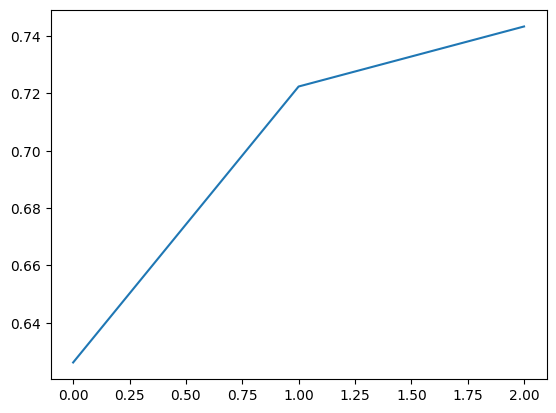

In [120]:
# plt.plot(history.history["loss"])
plt.plot(history.history["accuracy"])

In [121]:
stock = "^DJI"
saveToFile("test", stock)
test_data = np.loadtxt("csv/test/" + stock + ".csv", delimiter=",", skiprows=1, usecols=(1,2,3,4,5))
x_test = []

days = 100
n, m = test_data.shape
for i in range(n - days):
	sub = test_data[i:i + days,:]
	x_test.append(np.concatenate(sub, axis=0))
x_test = np.array(x_test)

y_test = test_data[days:, :]

val_loss, val_acc = model.evaluate(x_test, y_test)
print(val_loss, val_acc)

243/243 [==============================] - 1s 2ms/step - loss: 196.4768 - accuracy: 0.9265
196.47682189941406 0.9264611005783081


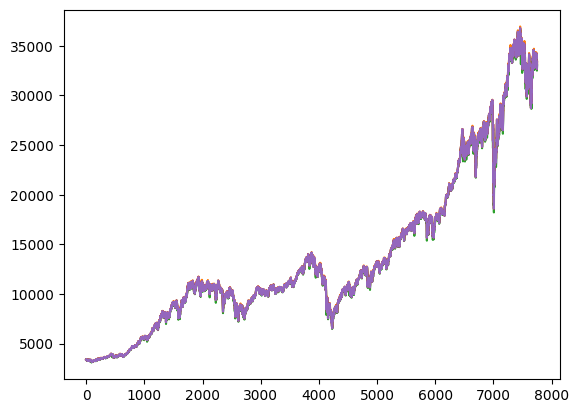

In [122]:
plt.plot(y_test)

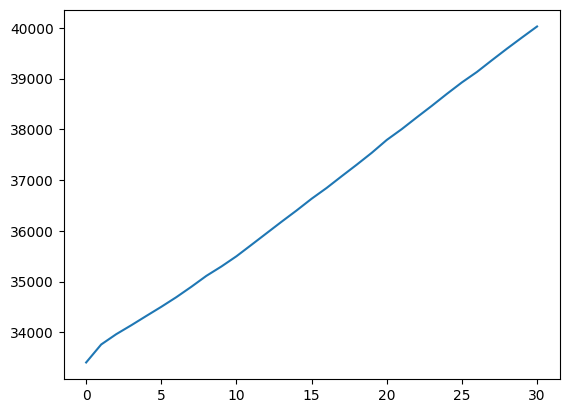

In [123]:
# 預測未來predict_days天的趨勢
predict_days = 30

highs = [y_test[-1][1]]

next = x_test[-1].reshape(1, -1)
for _ in range(predict_days):
    pred = model.predict(next, verbose=0)
    highs.append(pred[0][1])
    next = np.concatenate((next[:, 5:], pred), axis=1)

plt.plot(highs)

In [124]:
model.save("stock-predict.model")

INFO:tensorflow:Assets written to: stock-predict.model\assets


INFO:tensorflow:Assets written to: stock-predict.model\assets


In [ ]:
import yahoo_fin.stock_info as si
dow = si.tickers_other()
print(dow)

['A', 'AA', 'AAA', 'AAAU', 'AAC', 'AAC.U', 'AAC.W', 'AAIC', 'AAIC$B', 'AAIC$C', 'AAIN', 'AAM$A', 'AAM$B', 'AAMC', 'AAN', 'AAP', 'AAT', 'AAU', 'AB', 'ABB', 'ABBV', 'ABC', 'ABEQ', 'ABEV', 'ABG', 'ABM', 'ABR', 'ABR$D', 'ABR$E', 'ABR$F', 'ABT', 'AC', 'ACA', 'ACAQ', 'ACAQ.U', 'ACAQ.W', 'ACCO', 'ACEL', 'ACES', 'ACHR', 'ACHR.W', 'ACI', 'ACIO', 'ACM', 'ACN', 'ACP', 'ACP$A', 'ACR', 'ACR$C', 'ACR$D', 'ACRE', 'ACRO', 'ACRO.U', 'ACRO.W', 'ACSI', 'ACTV', 'ACU', 'ACV', 'ACVF', 'ACWV', 'ADC', 'ADC$A', 'ADCT', 'ADEX', 'ADEX.U', 'ADEX.W', 'ADFI', 'ADIV', 'ADM', 'ADME', 'ADNT', 'ADPV', 'ADRT', 'ADRT.U', 'ADT', 'ADX', 'AE', 'AEE', 'AEF', 'AEFC', 'AEG', 'AEL', 'AEL$A', 'AEL$B', 'AEM', 'AEMB', 'AENZ', 'AEO', 'AER', 'AES', 'AESC', 'AESR', 'AEVA', 'AEVA.W', 'AFB', 'AFG', 'AFGB', 'AFGC', 'AFGD', 'AFGE', 'AFIF', 'AFK', 'AFL', 'AFLG', 'AFMC', 'AFSM', 'AFT', 'AFTR', 'AFTR.U', 'AFTR.W', 'AFTY', 'AG', 'AGAC', 'AGAC.U', 'AGCO', 'AGD', 'AGE', 'AGG', 'AGGH', 'AGGY', 'AGI', 'AGIH', 'AGL', 'AGM', 'AGM$C', 'AGM$D', 'AGM